# Setup

## Imports

In [79]:
import pandas as pd

from vaiutils import path_consts, handle_files
from os.path import exists
from tqdm import tqdm_notebook
from itertools import combinations

## Define useful variables and functions

In [2]:
for k, v in path_consts('StateFarm'):
    exec(k + '=v')

In [160]:
FRAC_VALID = 0.15
FRAC_SAMPLE = 0.1
FRAC_SAMPLE_VALID = 0.3

In [4]:
DIR_TRAIN = DIR_DATA + '/train'
DIR_TEST = DIR_DATA + '/test'
DIR_VALID = DIR_DATA + '/valid'
DIR_RESULTS = DIR_DATA + '/results'
DIR_SAMPLE_TRAIN = DIR_DATA + '/sample/train'
DIR_SAMPLE_TEST = DIR_DATA + '/sample/test/unknown'
DIR_SAMPLE_VALID = DIR_DATA + '/sample/valid'
DIR_SAMPLE_RESULTS = DIR_DATA + '/sample/results'

# Make validation set

We need to use a different approach here. We can't blindly copy from the training set. The competition details make it clear that the test set has different drivers from the training set (if it wasn't clear already). This is logical since it reduces information leakage.

So, we approach this by taking a subset of the 26 drivers and using their images as validation data. Luckily Kaggle has provided a CSV which maps the drivers (using their IDs) to the images in the training set.

## Read the CSV

In [ ]:
driver_details = pd.read_csv(DIR_DATA + '/driver_imgs_list.csv')

The `driver_apperances` dictionary stores the number of times a driver has appeared in the training set

In [7]:
driver_appearances = {}
for driver in driver_details.subject.unique():
    driver_appearances[driver] = (
        len(driver_details.query("subject=='" + driver + "'")))

Let's visualize it

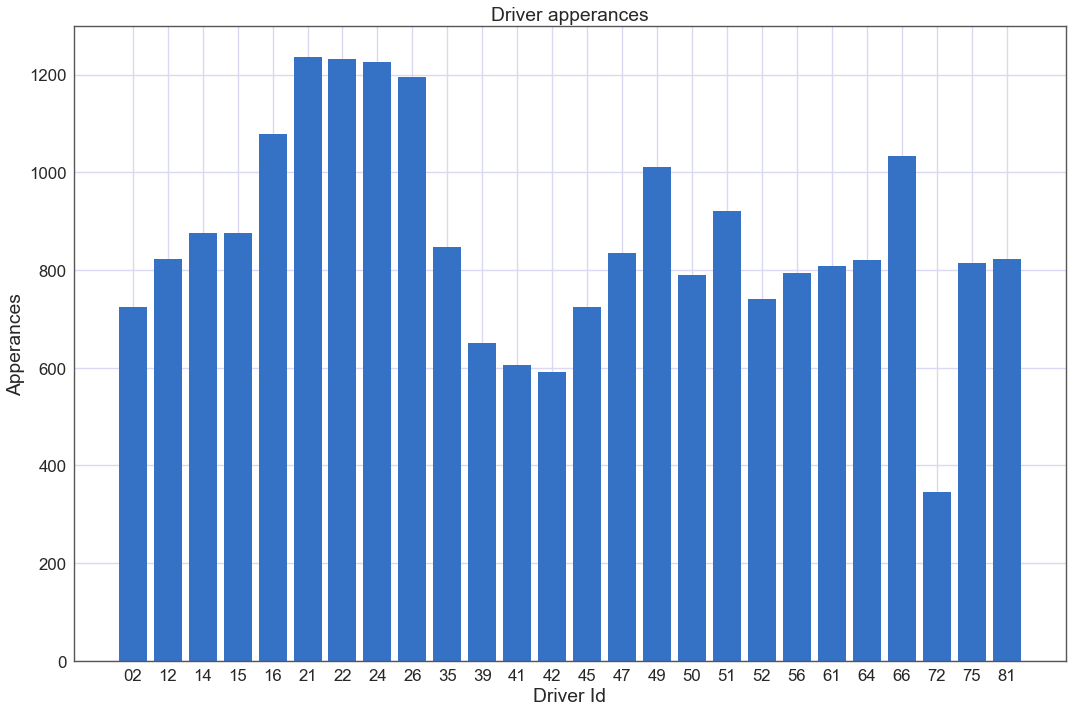

In [18]:
bar_x = range(driver_details.subject.nunique())
bar_y = list(driver_appearances.values())
bar_labels = [k[2:] for k in driver_appearances.keys()]
plt.bar(bar_x, bar_y, tick_label=bar_labels)
plt.xlabel('Driver Id')
plt.ylabel('Apperances')
plt.title('Driver apperances')
plt.show()

As expected, the distribution is moderately non-uniform.

## Get the drivers

If we fix the validation fraction, then it is reasonable to find the drivers with the maximum appearances, add their appearances one-by-one until we exceed the desired length of validation.
This gives us the minimum number of drivers.
If we start with the drivers with minimum appearances and do the same, we get the minimum number of drivers.

In [146]:
len_train = len(driver_details)
len_valid = int(FRAC_VALID * len_train)


def find_valid_drivers(driver_ids):
    total_len_valid = 0
    valid_drivers = []
    for driver_id in driver_ids:
        valid_drivers.append(driver_id)
        total_len_valid += driver_appearances[driver_id]

        if total_len_valid >= len_valid:
            if total_len_valid - len_valid < len_valid -(total_len_valid- driver_appearances[driver_id]):
                valid_drivers.pop()
            break

    return valid_drivers


min_drivers = len(find_valid_drivers(
    sorted(driver_appearances, key=driver_appearances.get, reverse=True)))
max_drivers = len(find_valid_drivers(
    sorted(driver_appearances, key=driver_appearances.get)))

Given a list of drivers, this function returns their total appearances

In [ ]:
def sum_appearances(driver_list):
    driver_keys = np.array(list(driver_appearances.keys()))[driver_list]
    return np.sum(np.array([driver_appearances[k] for k in driver_keys]))

Within the allowed range, we can get all the deviations from the desired length and find the combination which gives minimum deviation.

In [150]:
driver_combinations = {}
for i in tqdm_notebook(range(min_drivers, max_drivers + 1)):
    for drivers in tqdm_notebook(combinations(range(len(driver_appearances)), i)):
        driver_combinations[drivers] = abs(
            len_valid - sum_appearances(list(drivers)))

In [151]:
valid_drivers_pos = sorted(driver_combinations, key=driver_combinations.get)[0]
valid_drivers = np.array(list(driver_appearances.keys()))[
    list(valid_drivers_pos)]

Get all the filenames for the validation set (this is done so that the drivers in the training and validation sets do not overlap)

In [156]:
valid_filenames = []
for driver in valid_drivers:
    valid_filenames += list(driver_details.query("subject=='" +
                                                 driver + "'").img)

A sanity check. Should be low (subjectively speaking)

In [157]:
print("Percentage error: {}%".format(np.round(abs(len(valid_filenames) - len_valid) * 100 / len_train, 2)))

Percentage error: 0.0%


## Handle the files

In [158]:
for class_name in range(10):
    handle_files(DIR_TRAIN + '/c' + str(class_name), DIR_VALID +
                 '/c' + str(class_name), valid_filenames, 'move')

/home/vaisakh/.data/StateFarm/train/c0
/home/vaisakh/.data/StateFarm/train/c1
/home/vaisakh/.data/StateFarm/train/c2
/home/vaisakh/.data/StateFarm/train/c3
/home/vaisakh/.data/StateFarm/train/c4
/home/vaisakh/.data/StateFarm/train/c5
/home/vaisakh/.data/StateFarm/train/c6
/home/vaisakh/.data/StateFarm/train/c7
/home/vaisakh/.data/StateFarm/train/c8
/home/vaisakh/.data/StateFarm/train/c9


# Create samples

In [159]:
for class_name in range(10):
    handle_files(DIR_TRAIN + '/c' + str(class_name), DIR_SAMPLE_TRAIN +
                 '/c' + str(class_name), FRAC_SAMPLE, 'copy')

/home/vaisakh/.data/StateFarm/train/c0
/home/vaisakh/.data/StateFarm/train/c1
/home/vaisakh/.data/StateFarm/train/c2
/home/vaisakh/.data/StateFarm/train/c3
/home/vaisakh/.data/StateFarm/train/c4
/home/vaisakh/.data/StateFarm/train/c5
/home/vaisakh/.data/StateFarm/train/c6
/home/vaisakh/.data/StateFarm/train/c7
/home/vaisakh/.data/StateFarm/train/c8
/home/vaisakh/.data/StateFarm/train/c9


For validation sample, the number of files will be too low if 20% is used. Aim for 1000 validation images

In [161]:
for class_name in range(10):
    handle_files(DIR_VALID + '/c' + str(class_name), DIR_SAMPLE_VALID +
                 '/c' + str(class_name), FRAC_SAMPLE_VALID, 'copy')

/home/vaisakh/.data/StateFarm/valid/c0
/home/vaisakh/.data/StateFarm/valid/c1
/home/vaisakh/.data/StateFarm/valid/c2
/home/vaisakh/.data/StateFarm/valid/c3
/home/vaisakh/.data/StateFarm/valid/c4
/home/vaisakh/.data/StateFarm/valid/c5
/home/vaisakh/.data/StateFarm/valid/c6
/home/vaisakh/.data/StateFarm/valid/c7
/home/vaisakh/.data/StateFarm/valid/c8
/home/vaisakh/.data/StateFarm/valid/c9


In [162]:
handle_files(DIR_TEST, DIR_SAMPLE_TEST, FRAC_SAMPLE, 'copy')

/home/vaisakh/.data/StateFarm/test


# Move Test to Unknown

Keras doesn't like it otherwise

In [163]:
%cd $DIR_TEST
%mkdir unknown
%mv * unknown

/home/vaisakh/.data/StateFarm/test
mv: cannot move 'unknown' to a subdirectory of itself, 'unknown/unknown'
